prep and load data

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from sklearn_pandas import DataFrameMapper

dataset = pd.read_csv("D:/advnet-project/codes/dataset/processed_dataset.csv")
batch_size = 64
fe_data = dataset.copy()
fe_data = fe_data.drop(["Label", "Cat"], axis = 1)
le = preprocessing.LabelEncoder()
for column_name in fe_data.columns:
    if fe_data[column_name].dtype == object:
        fe_data[column_name] = le.fit_transform(fe_data[column_name])
    else:
        pass
fe_data.replace([np.inf, -np.inf], np.nan, inplace=True)
fe_data.dropna(inplace=True)
fe_datay = fe_data.Sub_Cat
fe_data = fe_data.drop(["Sub_Cat"], axis = 1)
scaler = StandardScaler()
mapper = DataFrameMapper([(fe_data.columns, StandardScaler())])
scaled_features = mapper.fit_transform(fe_data.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=fe_data.index, columns=fe_data.columns)
fe_datax = scaled_features_df
fex_tt, fex_pred, fey_tt, fey_pred = train_test_split(fe_datax, fe_datay, test_size = 0.1, random_state = 7)
fex_train, fex_valid, fey_train, fey_valid = train_test_split(fex_tt, fey_tt, test_size = 0.3, random_state = 7)

dataset = pd.read_csv("D:/advnet-project/codes/dataset/processed_dataset.csv")
batch_size = 64
fe_data = dataset.copy()
fe_data = fe_data.drop(["Label", "Sub_Cat"], axis = 1)
fe_datax = fe_data.drop(["Cat"], axis = 1)
fe_datay = fe_data.Cat
fex_train, fex_valid, fey_train, fey_valid = train_test_split(fe_datax, fe_datay, test_size = 0.3, random_state = 7)

In [3]:
fe_datax.head()

,Flow_ID,Src_Port,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,...,Src_IP_oct2,Src_IP_oct3,Src_IP_oct4,Dst_IP_oct1,Dst_IP_oct2,Dst_IP_oct3,Dst_IP_oct4,Day_of_Week,Hour,AM_PM
0,-0.736911,-1.011778,-0.358338,1.307488,0.517715,-0.160332,-0.156791,-0.384331,0.353615,0.288776,...,0.341750,-0.480216,-0.525337,0.040215,0.469991,-0.688465,-0.639819,0.093974,-0.254177,-0.323924
1,-0.250776,-1.328144,-0.902186,-0.737598,-1.836372,1.336352,-0.156791,0.435478,-0.491379,-0.536796,...,0.107449,2.247254,1.196177,0.040215,0.469991,-0.688465,-0.700209,-0.900367,3.003822,3.087146
2,-0.725363,0.716565,-0.419918,-0.737598,-0.287383,-0.141462,-0.388745,1.255288,-0.491379,1.083172,...,0.341750,-0.480216,-0.481938,0.040215,0.469991,-0.688465,-0.700209,0.093974,-0.597124,-0.323924
3,-0.724750,0.726152,-0.419918,-0.737598,1.061979,-0.138603,-0.388745,0.435478,-0.491379,1.065852,...,0.341750,-0.480216,-0.481938,0.040215,0.469991,-0.688465,-0.700209,2.082654,-0.254177,-0.323924
4,-1.294735,0.070808,-0.825511,1.307488,1.296447,-0.138031,0.075163,-0.384331,0.271009,-0.294320,...,0.341750,-0.480216,-0.698935,1.634563,2.506090,2.446245,4.070615,1.088314,-0.597124,-0.323924


In [4]:
fe_datay.unique()

array([2, 0, 8, 4, 5, 3, 6, 7, 1])

define reusable metric func

In [5]:
def evaluate_multiclass_classification(y_true, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)

    # Calculate False Positive Rate (FPR) for each class
    # FPR = FP / (FP + TN)
    fpr = [cm[i, :].sum() - cm[i, i] / (cm[i, :].sum()) for i in range(len(cm))]

    # Calculate macro-averaged precision, recall, and FPR
    macro_precision = sum(precision) / len(precision)
    macro_recall = sum(recall) / len(recall)
    macro_fpr = sum(fpr) / len(fpr)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "FPR": fpr,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro FPR": macro_fpr
    }

In [6]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    # Extract the classes and their corresponding precision, recall, and accuracy
    classes = range(len(metrics['Precision']))
    precision = metrics['Precision']
    recall = metrics['Recall']
    accuracy = metrics['Accuracy']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot Precision
    axes[0].bar(classes, precision, tick_label=classes)
    axes[0].set_title('Precision')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Precision')

    # Plot Recall
    axes[1].bar(classes, recall, tick_label=classes)
    axes[1].set_title('Recall')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Recall')

    # Plot Accuracy
    axes[2].bar(['Accuracy'], [accuracy])
    axes[2].set_title('Accuracy')
    axes[2].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

AutoEncoder

In [7]:
import tensorflow as tf

input_dim = fex_train.shape[1]
input_layer = tf.keras.layers.Input(shape=(input_dim,))
hidden_layer = tf.keras.layers.Dense(40, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(hidden_layer)
autoencoder = tf.keras.models.Model(input_layer, output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(fex_train, fex_train, epochs=50, batch_size=32)




Epoch 1/50

12313/12313 [==============================] - 14s 1ms/step - loss: 0.5964
Epoch 2/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5887
Epoch 3/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5884
Epoch 4/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5882
Epoch 5/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5882
Epoch 6/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5881
Epoch 7/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5881
Epoch 8/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5881
Epoch 9/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5880
Epoch 10/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5880
Epoch 11/50
12313/12313 [==============================] - 13s 1ms/step - loss: 0.5880
Epoch 12/50
12313/12313 [=======================

Validation

In [8]:
reconstructed_test_data = autoencoder.predict(fex_valid)
reconstruction_error = tf.reduce_mean(tf.square(fex_valid - reconstructed_test_data), axis=1)

5277/5277 [==============================] - 5s 855us/step


In [9]:
predictions = reconstruction_error > 0.95
print(predictions)

tf.Tensor([False False False ... False False False], shape=(168862,), dtype=bool)


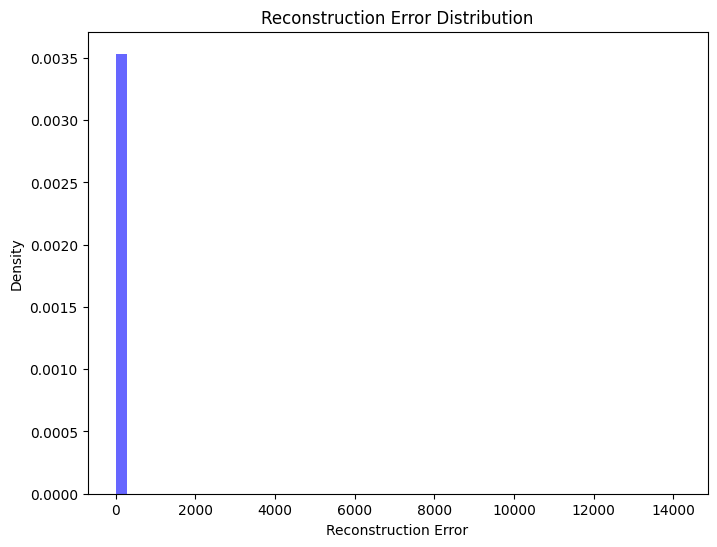

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(reconstruction_error, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution")
plt.show()

Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier as DT

class DecisionTree():
    model = any

    def create_model(self):
        self.model = DT(
            criterion = 'gini',
            splitter = 'best',
            max_depth = 100,
            min_samples_split = 2,
            min_samples_leaf = 1
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)
    
    def get_model(self):
        return self.model

    def __init__(self) -> None:
        self.create_model()

trainset = [fex_train, fey_train]
dtm = DecisionTree()
dtm.train_model(trainset)

Validation

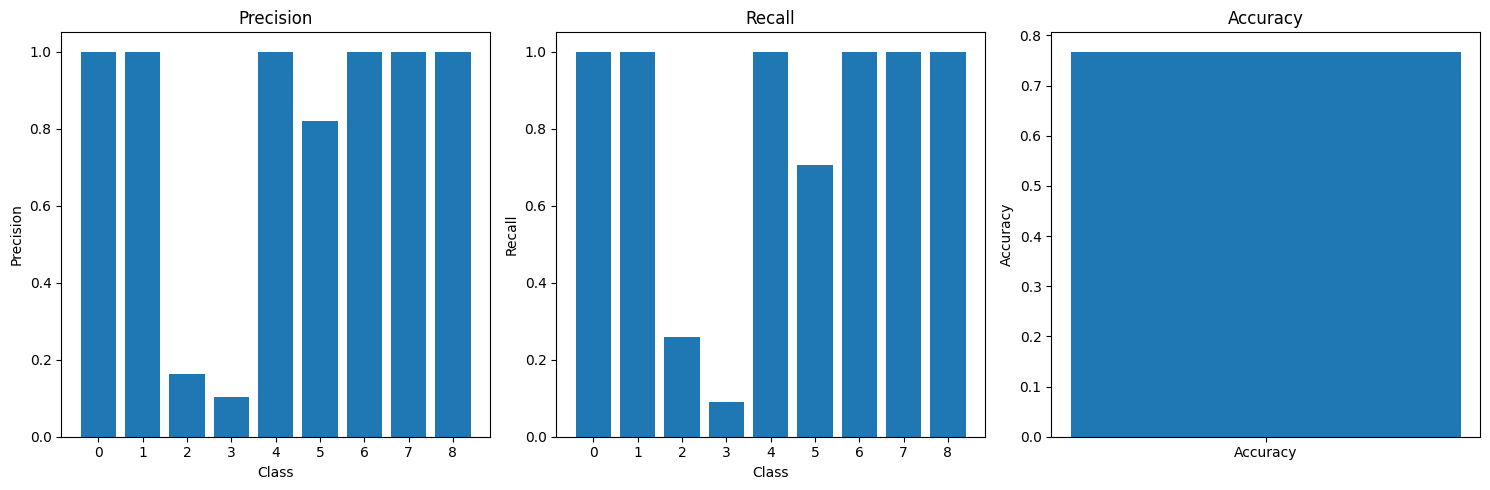

In [12]:
predictions = dtm.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

Gaussian NB

In [13]:
from sklearn.naive_bayes import GaussianNB as GNB

class GaussionNaiveBayes():
    model = any

    def create_model(self):
        self.model = GNB()

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)
    
    def get_model(self):
        return self.model

    def __init__(self) -> None:
        self.create_model()

gnb = GaussionNaiveBayes()
gnb.train_model(trainset)

Validation

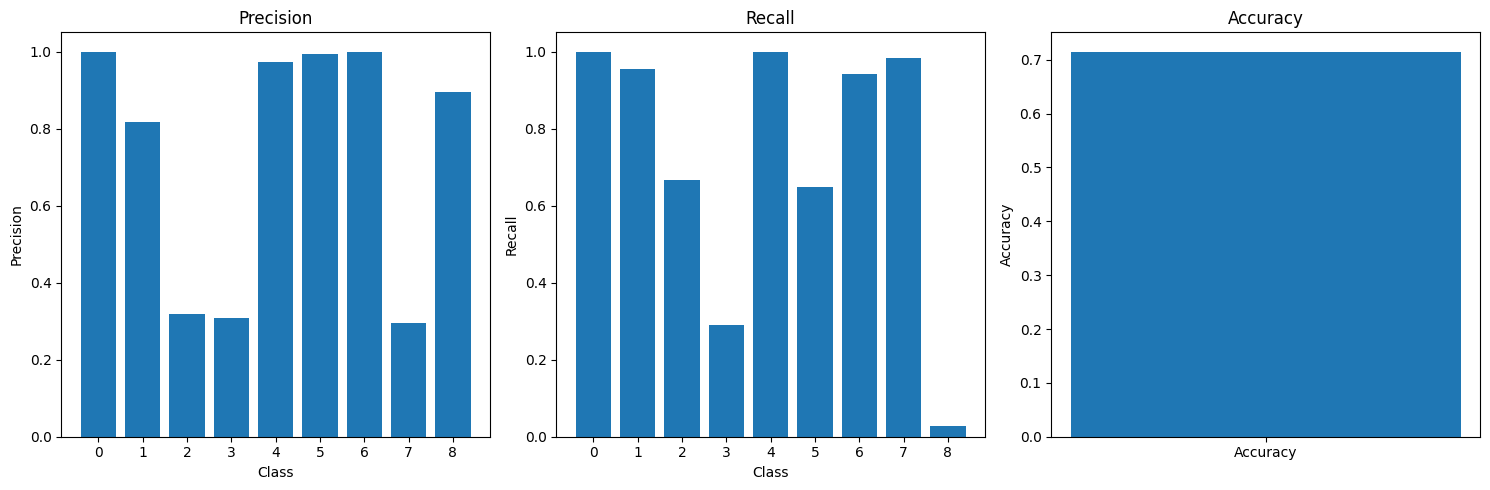

In [14]:
predictions = gnb.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

class LinearDiscriminantAnalysis():
    model = any

    def create_model(self):
        self.model = LDA(
            n_components = None,
            priors = None,
            shrinkage = None,
            solver = 'svd',
            store_covariance = False,
            tol = 0.0001
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)
    
    def get_model(self):
        return self.model

    def __init__(self) -> None:
        self.create_model()

lda = LinearDiscriminantAnalysis()
lda.train_model(trainset)

Validation

D:\advnet-project\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


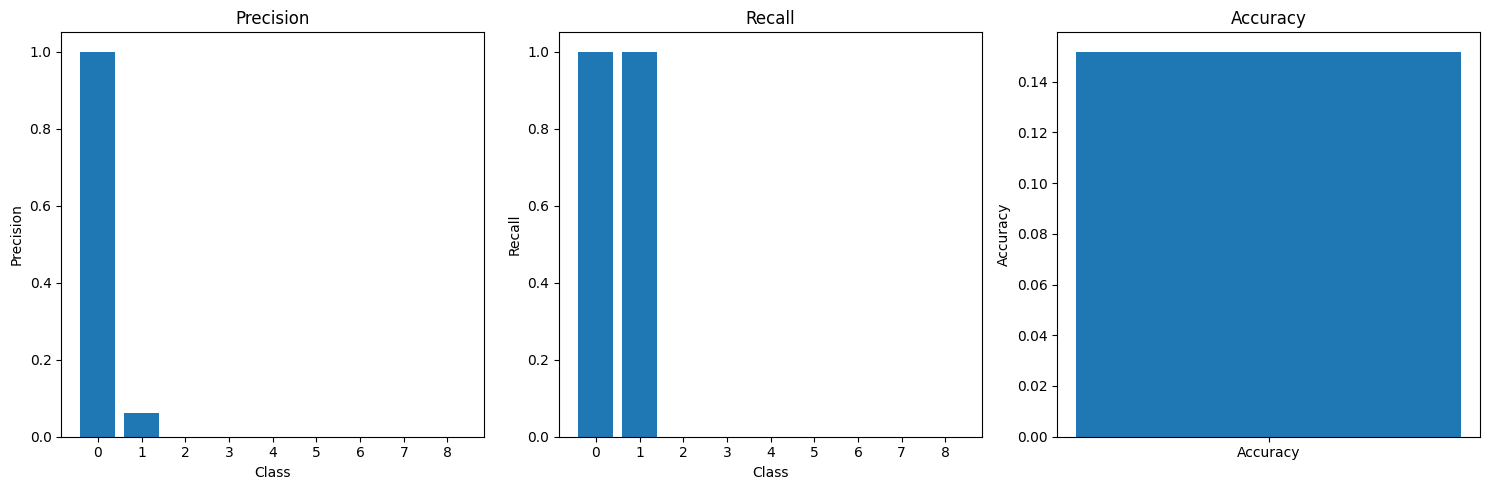

In [16]:
predictions = lda.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

LogReg

In [17]:
from sklearn.linear_model import LogisticRegression as LR

class LogisticRegression():
    model = any

    def create_model(self):
        self.model = LR(
            penalty = 'l2',
            dual = False,
            tol = 0.0001,
            C = 1.0,
            fit_intercept = True,
            intercept_scaling = 1,
            solver = 'sag',
            max_iter = 100,
            multi_class = 'ovr',
            verbose = 0,
            warm_start = False,
            l1_ratio = None
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)
    
    def get_model(self):
        return self.model

    def __init__(self) -> None:
        self.create_model()

lr = LogisticRegression()
lr.train_model(trainset)

D:\advnet-project\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\advnet-project\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\advnet-project\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\advnet-project\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\advnet-project\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\advnet-project\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Validation

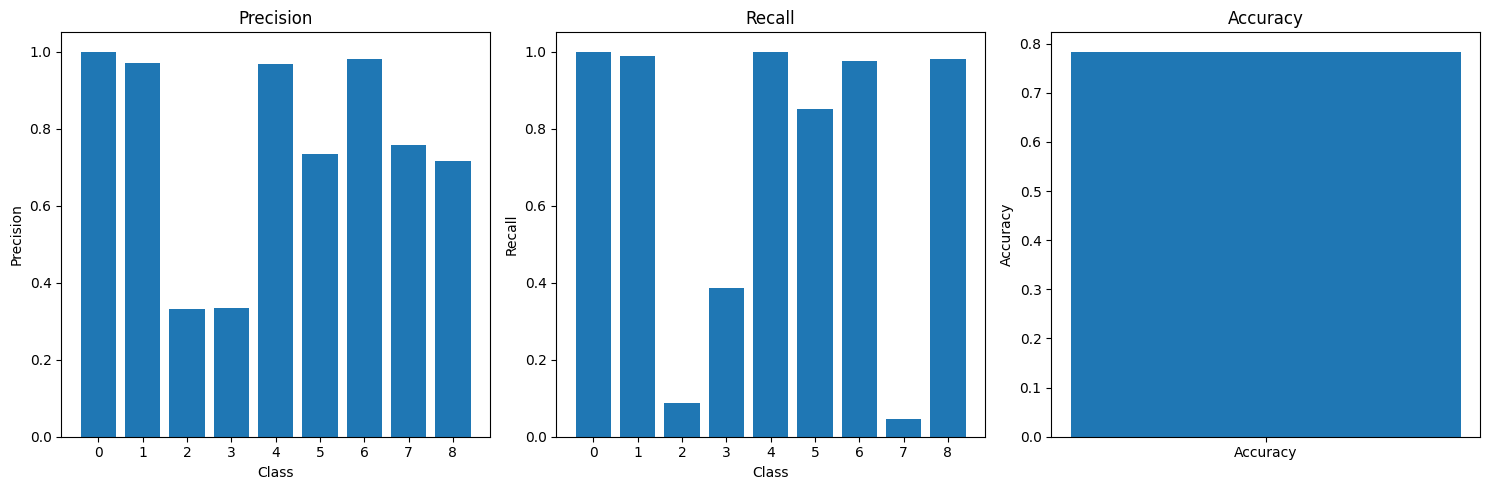

In [18]:
predictions = lr.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

RF

In [19]:
from sklearn.ensemble import RandomForestClassifier as RF

class RandomForest():
    model = any

    def create_model(self):
        self.model = RF(
            n_estimators = 10,
            criterion = 'gini',
            max_depth = 100
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)
    
    def get_model(self):
        return self.model

    def __init__(self) -> None:
        self.create_model()

rf = RandomForest()
rf.train_model(trainset)

Validation

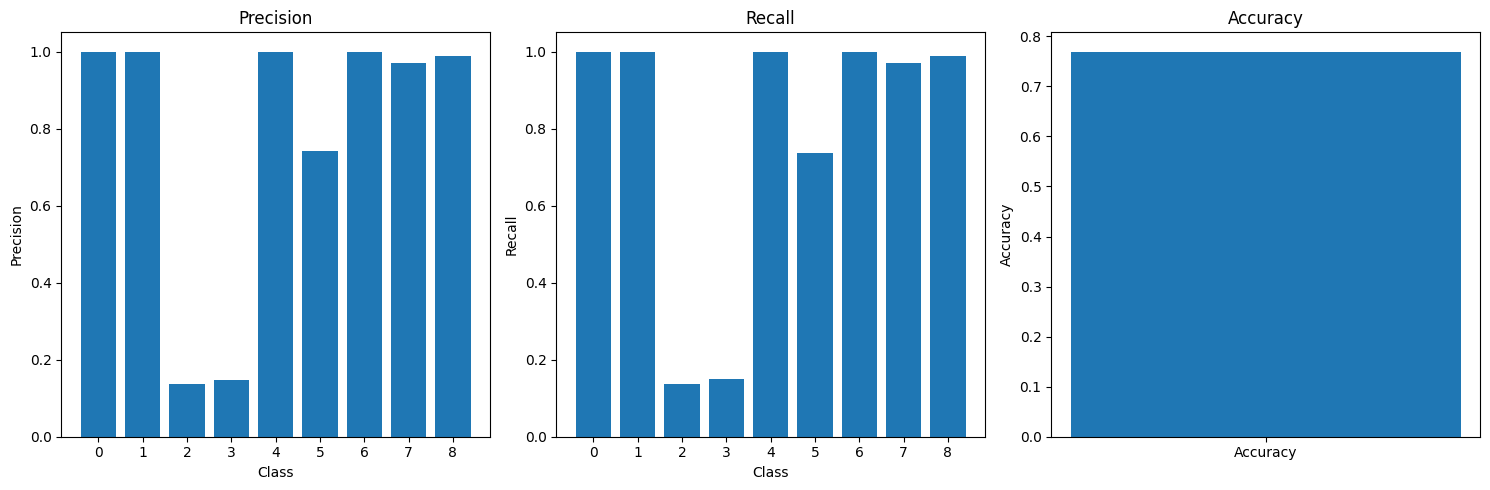

In [20]:
predictions = rf.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

SVM

In [21]:
from sklearn.svm import SVC

class SupportVectorMachine():
    model = any

    def create_model(self):
        self.model = SVC(
            C = 1,
            kernel = 'linear',
            decision_function_shape = 'ovr',
            max_iter = 1000
        )

    def train_model(self, trainset):
        data, label = trainset
        self.model.fit(data, label)

    def do_prediction(self, data):
        return self.model.predict(data)
    
    def get_model(self):
        return self.model

    def __init__(self) -> None:
        self.create_model()

svm = SupportVectorMachine()
svm.train_model(trainset)

D:\advnet-project\env\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation

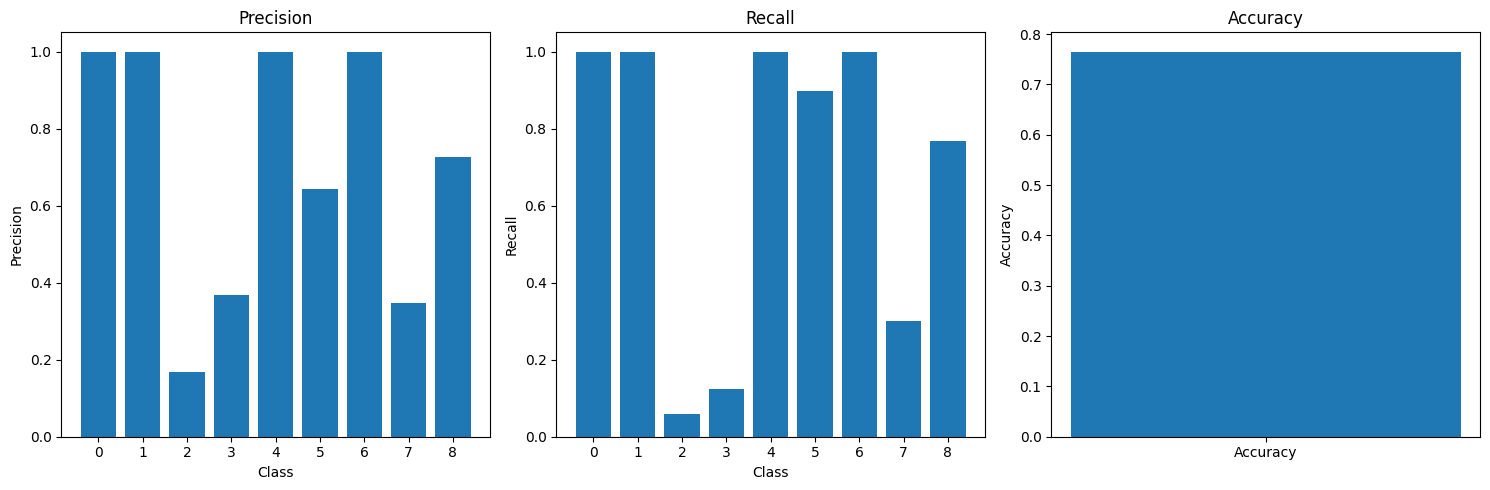

In [22]:
predictions = svm.do_prediction(fex_valid)
plot_metrics(evaluate_multiclass_classification(fey_valid, predictions))

In [23]:
import pickle

def save_model(model, filename):
    pickle.dump(model, open(f'{filename}.pkl', 'wb'))

def load_model(filename):
    pickled_model = pickle.load(open(f'{filename}.pkl', 'rb'))
    return pickled_model

In [24]:
models = [[autoencoder, "autoenc"], [dtm, "decisiontree"], [gnb, "naivebayes"], [lda, "lindisc"], [lr, "logreg"], [rf, "randforest"], [svm, "svm"]]
for model, file in models:
    save_model(model, file)